In [1]:
import pandas as pd

from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import re, os
import numpy as np

%matplotlib inline

In [2]:
headers = [l.strip() for l in open("./headers")]

In [3]:
df = pd.read_csv("../dataset/blogData_train.csv", header=None, names=headers, index_col=False)

In [4]:
files = ['../dataset/' + f for f in os.listdir('../dataset/') if re.match(r'blogData_test-2012.0[\d].[\d]{2}.[\d]{2}_[\d]{2}.csv', f)]
files.sort()

In [5]:
df_test = pd.read_csv("../dataset/blogData_test-2012.02.01.00_00.csv", header=None, names=headers, index_col=False)
for i in range(len(files)):
    df_test.append(pd.read_csv(files[i], header=None, names=headers, index_col=False))

In [6]:
df_test.shape

(115, 281)

In [7]:
# Log transforming the data
df['target_number_of_comments_in_next_24_hours'] = np.log(1 + df['target_number_of_comments_in_next_24_hours'])
df_test['target_number_of_comments_in_next_24_hours'] = np.log(1 + df_test['target_number_of_comments_in_next_24_hours'])

In [8]:
# Dropping continous variables without variation
df.drop(df.columns[[7, 12, 27, 32, 37, 39, 42, 49, 277]], axis=1, inplace=True)
df_test.drop(df_test.columns[[7, 12, 27, 32, 37, 39, 42, 49, 277]], axis=1, inplace=True)

In [9]:
df_test.shape

(115, 272)

In [10]:
df = df[df.length_of_blog_post > 100]

In [11]:
df.columns[271]

'target_number_of_comments_in_next_24_hours'

In [12]:
df_basic = df.iloc[:, list(range(54)) + [271]]
df_basic_text = df.iloc[:, list(range(254)) + [271]]
df_text = df.iloc[:, list(range(54, 254)) + [271]]

df_basic_test = df_test.iloc[:, list(range(54)) + [271]]
df_basic_text_test = df_test.iloc[:, list(range(254)) + [271]]
df_text_test = df_test.iloc[:, list(range(54, 254)) + [271]]

In [13]:
def get_xy(df):
    array = df.values
    X = array[:, 0:df.shape[1]-1]
    Y = array[:, df.shape[1]-1]
    return X, Y

In [14]:
def model(X_train, y_train, X_test, y_test):
    evaluation = dict()
    
    evaluation['baseline'] = mean_squared_error(y_test, [y_train.mean()] * len(y_test))
    
    # Lasso Regression
    model = Lasso()
    model.fit(X_train, y_train)
    evaluation['lasso'] = mean_squared_error(y_test, model.predict(X_test))

    # KNN Regression
    model = KNeighborsRegressor(n_neighbors=20)
    model.fit(X_train, y_train)
    evaluation['knn'] = mean_squared_error(y_test, model.predict(X_test))
    
    model = MLPRegressor((10,5))
    model.fit(X_train, y_train)
    evaluation['mlp'] = mean_squared_error(y_test, model.predict(X_test))

    # DecisionTree Regression
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    evaluation['dtree'] = mean_squared_error(y_test, model.predict(X_test))

    # MLP Regression
    
    model1 = RandomForestRegressor()
    model1.fit(X_train, y_train)
    y_pred_1 = model1.predict(X_test)
    evaluation['rforest'] = mean_squared_error(y_test, y_pred_1)

    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluation['gboost'] = mean_squared_error(y_test, y_pred)
    
    evaluation['bagg'] = mean_squared_error(y_test, 0.5 * y_pred + 0.5 * y_pred_1)
    
    evaluation['boost'] = mean_squared_error(y_test, 0.75 * y_pred + 0.25 * y_pred_1)

#     model = AdaBoostRegressor()
#     model.fit(X_train, y_train)
#     evaluation['adaboost'] = mean_squared_error(y_test, model.predict(X_test))

    
    
    return evaluation

In [15]:
def start_PCA(df, df_test, comp=20):
    X, Y = get_xy(df)
    X_test, Y_test = get_xy(df_test)
    clf = PCA(n_components=comp)
    clf.fit(X, Y)
    X = clf.transform(X)
    X_test = clf.transform(X_test)
    return model(X, Y, X_test, Y_test)

In [19]:
pca_basic = start_PCA(df_basic, df_basic_test, 20)
pca_basic_text = start_PCA(df_basic_text, df_basic_text_test, 20)
pca_text = start_PCA(df_text, df_text_test, 20)

In [20]:
import pprint
pprint.pprint(pca_basic)
pprint.pprint(pca_basic_text)
pprint.pprint(pca_text)    

{'bagg': 0.72228863495606699,
 'baseline': 1.3684261978409,
 'boost': 0.73342578088608201,
 'dtree': 1.5380523878106176,
 'gboost': 0.77381502855337003,
 'knn': 0.92279957516174849,
 'lasso': 0.8088113530578156,
 'mlp': 1.2948369348008921,
 'rforest': 0.78777064830785626}
{'bagg': 0.69897456073115938,
 'baseline': 1.3684261978409,
 'boost': 0.72470003693664342,
 'dtree': 1.4943163062030616,
 'gboost': 0.78241549938091226,
 'knn': 0.92279957516174849,
 'lasso': 0.80880872557886807,
 'mlp': 1.3192028116951282,
 'rforest': 0.74349356703654623}
{'bagg': 1.4112574305496992,
 'baseline': 1.3684261978409,
 'boost': 1.3515685037589524,
 'dtree': 2.5326621568858503,
 'gboost': 1.3086260905928828,
 'knn': 1.4697739541913419,
 'lasso': 1.3684261978409,
 'mlp': 1.3039859510814369,
 'rforest': 1.5808748250052247}


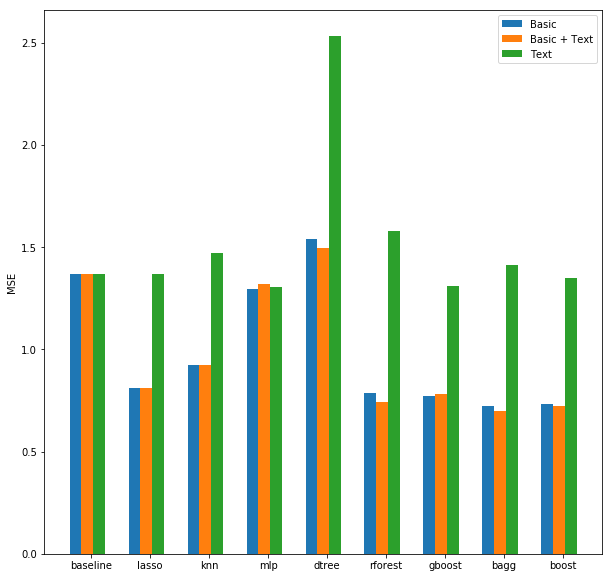

In [21]:
import matplotlib.pyplot as plt

keys = pca_basic.keys()
y = [pca_basic[key] for key in keys]
z= [pca_basic_text[key] for key in keys]
k= [pca_text[key] for key in keys]

x =len(pca_basic.keys())

ind = np.arange(x) 
width = 0.2
plt.figure(figsize=(10,10))
plt.bar(ind-width, y, width, label='Basic')
plt.bar(ind, z, width, label='Basic + Text')
plt.bar(ind + width, k, width,
    label='Text')

plt.ylabel('MSE')

plt.xticks(ind + width / 3, keys)
plt.legend(loc='best')
plt.show()

In [22]:
def start_ETR(df, df_test):
    X, Y = get_xy(df)
    X_test, Y_test = get_xy(df_test)
    clf = ExtraTreesRegressor()
    clf.fit(X, Y)
    imp = clf.feature_importances_
    indices = np.argpartition(imp, -20,)[-20:]
    X = df.iloc[:, indices].values
    X_test = df_test.iloc[:, indices].values
    return model(X, Y, X_test, Y_test)

In [23]:
etr_basic = start_ETR(df_basic, df_basic_test)
etr_basic_text = start_ETR(df_basic_text, df_basic_text_test)
etr_text = start_ETR(df_text, df_text_test)

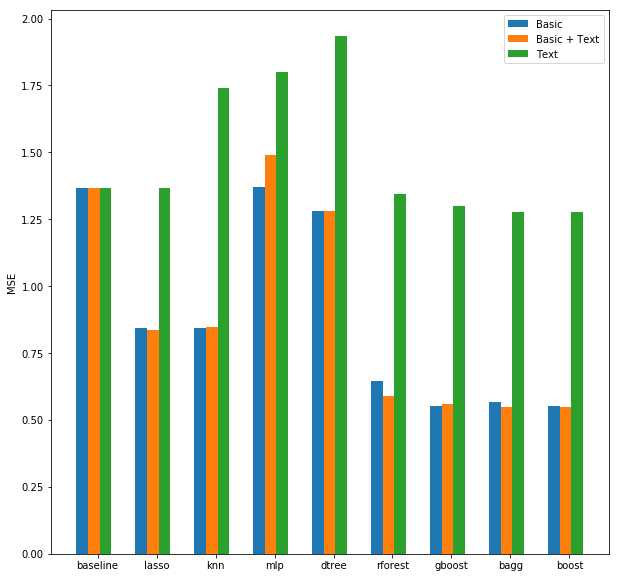

In [24]:
import matplotlib.pyplot as plt

etr_basic['mlp'] = 1.37
etr_basic_text['mlp']= 1.489
etr_text['mlp'] = 1.8
etr_text['knn'] = 1.74

keys = etr_basic.keys()
y = [etr_basic[key] for key in keys]
z= [etr_basic_text[key] for key in keys]
k= [etr_text[key] for key in keys]

x =len(etr_basic.keys())

ind = np.arange(x) 
width = 0.2
plt.figure(figsize=(10,10))
plt.bar(ind-width, y, width, label='Basic')
plt.bar(ind, z, width, label='Basic + Text')
plt.bar(ind + width, k, width,
    label='Text')

plt.ylabel('MSE')

plt.xticks(ind + width / 3, keys)
plt.legend(loc='best')
plt.show()

In [25]:
# k=20, mlp=10,5
import pprint
pprint.pprint(etr_basic)
pprint.pprint(etr_basic_text)
pprint.pprint(etr_text)

{'bagg': 0.56788536816012769,
 'baseline': 1.3684261978409,
 'boost': 0.55285490707213736,
 'dtree': 1.2806023638546213,
 'gboost': 0.55366502864137246,
 'knn': 0.84356882266925493,
 'lasso': 0.84349516525801593,
 'mlp': 1.37,
 'rforest': 0.64546803830778487}
{'bagg': 0.54780760250217919,
 'baseline': 1.3684261978409,
 'boost': 0.54706098480379373,
 'dtree': 1.2818947890260075,
 'gboost': 0.55933455400836163,
 'knn': 0.8478566463757895,
 'lasso': 0.8351460262430539,
 'mlp': 1.489,
 'rforest': 0.58836139860780901}
{'bagg': 1.2775401952440488,
 'baseline': 1.3684261978409,
 'boost': 1.2778395828092028,
 'dtree': 1.9343486355573192,
 'gboost': 1.3010097552863751,
 'knn': 1.74,
 'lasso': 1.3684261978409,
 'mlp': 1.8,
 'rforest': 1.3455537748497974}


In [30]:
for key in pca_basic.keys():
    print(("{} & {:.4f} & {:.4f} & {:.4f} & {:.4f} & {:.4f} & {:.4f}").format(key, pca_basic[key], pca_basic_text[key],
                                                     pca_text[key], etr_basic[key], etr_basic_text[key], etr_text[key]))

baseline & 1.3684 & 1.3684 & 1.3684 & 1.3684 & 1.3684 & 1.3684
lasso & 0.8088 & 0.8088 & 1.3684 & 0.8435 & 0.8351 & 1.3684
knn & 0.9228 & 0.9228 & 1.4698 & 0.8436 & 0.8479 & 1.7400
mlp & 1.2948 & 1.3192 & 1.3040 & 1.3700 & 1.4890 & 1.8000
dtree & 1.5381 & 1.4943 & 2.5327 & 1.2806 & 1.2819 & 1.9343
rforest & 0.7878 & 0.7435 & 1.5809 & 0.6455 & 0.5884 & 1.3456
gboost & 0.7738 & 0.7824 & 1.3086 & 0.5537 & 0.5593 & 1.3010
bagg & 0.7223 & 0.6990 & 1.4113 & 0.5679 & 0.5478 & 1.2775
boost & 0.7334 & 0.7247 & 1.3516 & 0.5529 & 0.5471 & 1.2778


In [31]:
result = dict()
i = 1
for df, df_test in [(df_basic, df_basic_test), (df_basic_text,df_basic_text_test), (df_text, df_text_test)]:
    X_train, Y_train = get_xy(df)
    X_test, Y_test = get_xy(df_test)
    clf = PCA()
    clf.fit(X_train, Y_train)
    X_train = clf.transform(X_train)
    val = dict()
    for k in list(range(1, 100)):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, Y_train)
        val[k] = mean_squared_error(Y_test, model.predict(X_test))
    result[i] = val
    i += 1

In [ ]:
results[3].max()

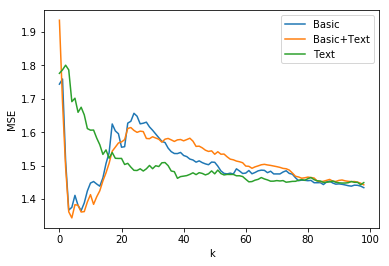

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
results = pd.DataFrame.from_dict(result)
plt.plot(range(len(results[1].values)), results[1].values, label='Basic')
plt.plot(range(len(results[2].values)), results[2].values, label='Basic+Text')
plt.plot(range(len(results[3].values)), results[3].values, label='Text')
plt.xlabel("k")
plt.legend()
plt.ylabel("MSE")
plt.show()

In [36]:
results[2].min()

1.3435851387587245